In [1]:
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
training_data = datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=ToTensor()
)
test_data = datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=ToTensor()
)

In [3]:
from torch.utils.data import DataLoader

training_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

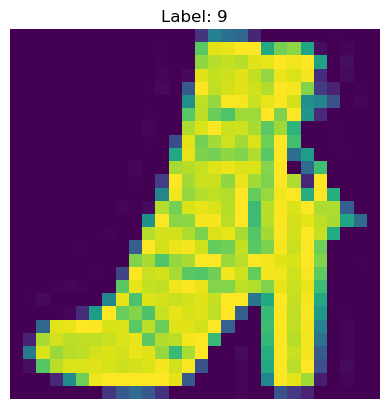

In [4]:
# For comparison between input and latent space
image, label = training_data[11]
plt.imshow(image.squeeze())  # squeeze removes the single channel dimension
plt.title(f'Label: {label}')
plt.axis('off')
plt.show()

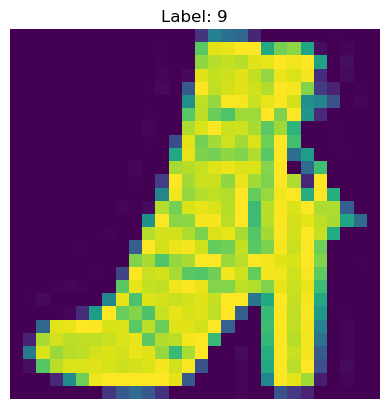

torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 56, 56])


In [5]:
image, label = training_data[11]
image = image.unsqueeze(0) # Add the first dimension 'batch'=1, to use interpolate (batch, channels, height, width)
upimg = nn.functional.interpolate(image,scale_factor=2,mode='nearest-exact')
plt.imshow(upimg.squeeze())  # squeeze removes the single channel dimension
plt.title(f'Label: {label}')
plt.axis('off')
plt.show()
print(image.size())
print(upimg.size())

In [6]:
class FashionAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding='same' ), # 28x28x16
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), # 14x14x16
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, padding='same'), # 14x14x8
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), # 7x7x8
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding='same'), # 7x7x8
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2), # 3x3x8, which is the latent space
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1) # 4x4x8, which is the latent space
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding='same'), # 4x4x8
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest-exact'), # 8x8x8
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding='same'), # 8x8x8
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest-exact'), # 16x16x8
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding='same'), # 16x16x8
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest-exact'), # 32x32x8        
            nn.Conv2d(in_channels=8, out_channels=1, kernel_size=5, padding=0), # 28x28x1
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [7]:
# Check for MPS availability (for Apple Silicon)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

model = FashionAutoencoder()
model.to(device) # Move model to MPS or CPU
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Using device: mps


In [8]:
epochs = 100
for epoch in range(epochs):
    # Each data is a batch of 64 images
    for data in training_dataloader:
        img, label = data
        img = img.to(device)
        optimizer.zero_grad()
        output = model(img)
        loss = loss_fn(output, img)
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [1/100], Loss: 0.2681
Epoch [2/100], Loss: 0.2764
Epoch [3/100], Loss: 0.3016
Epoch [4/100], Loss: 0.3173
Epoch [5/100], Loss: 0.2858
Epoch [6/100], Loss: 0.2880
Epoch [7/100], Loss: 0.2936
Epoch [8/100], Loss: 0.2969
Epoch [9/100], Loss: 0.2854
Epoch [10/100], Loss: 0.2721
Epoch [11/100], Loss: 0.3098
Epoch [12/100], Loss: 0.2895
Epoch [13/100], Loss: 0.2489
Epoch [14/100], Loss: 0.2906
Epoch [15/100], Loss: 0.2878
Epoch [16/100], Loss: 0.2981
Epoch [17/100], Loss: 0.3076
Epoch [18/100], Loss: 0.2858
Epoch [19/100], Loss: 0.3104
Epoch [20/100], Loss: 0.2684
Epoch [21/100], Loss: 0.2797
Epoch [22/100], Loss: 0.2927
Epoch [23/100], Loss: 0.2749
Epoch [24/100], Loss: 0.2681
Epoch [25/100], Loss: 0.2747
Epoch [26/100], Loss: 0.2786
Epoch [27/100], Loss: 0.2714
Epoch [28/100], Loss: 0.2960
Epoch [29/100], Loss: 0.3098
Epoch [30/100], Loss: 0.2877
Epoch [31/100], Loss: 0.2913
Epoch [32/100], Loss: 0.2784
Epoch [33/100], Loss: 0.2767
Epoch [34/100], Loss: 0.2734
Epoch [35/100], Loss: 0

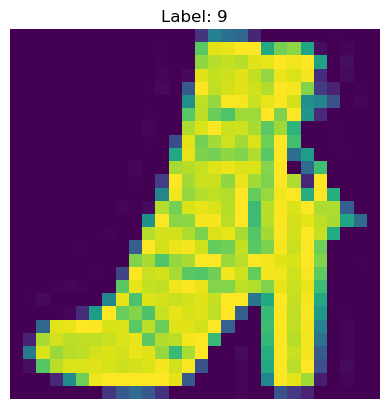

In [9]:
# Now testing the Autoencoder
# For comparison between input and latent space
image, label = training_data[11]
plt.imshow(image.squeeze())  # squeeze removes the single channel dimension
plt.title(f'Label: {label}')
plt.axis('off')
plt.show()

torch.Size([1, 1, 28, 28])


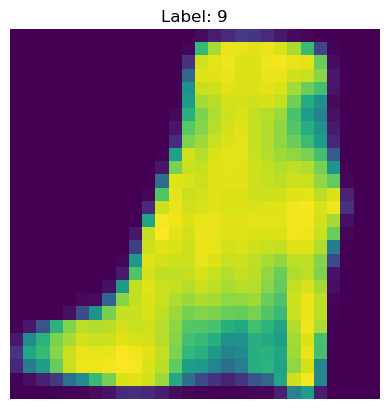

In [10]:
image, label = training_data[11]
image = image.unsqueeze(0).to(device) # Adding batch_size = 1
print(image.size())
output_img = model(image).detach().cpu()
# print(output_img.size())
# print(output_img.min())
# print(output_img.max())
plt.imshow(output_img.squeeze())  # squeeze removes the single channel dimension
plt.title(f'Label: {label}')
plt.axis('off')
plt.show()